# Проект "Предсказательная модель успешности стартапа"

## Описание проект

Нам предоставили исторические данные, в которых представлена информацияо стартапах, которые функционировали в период с 1980-2018 года. Необходимо написать модель, которая будет предсказывать какой стартап закроется, а какой нет. Также необходимо сформировать рекомендации для бизнеса, согласно которым владельцы начинающих стартапов будут понимать на какие моменты им необходимо обращать внимание, чтобы их стартап жил.

Теперь изучим наши датафреймы. У нас есть тренировочная выборка ***kaggle_startups_train_28062024*** и тестовая выборка ***kaggle_startups_test_28062024***. Оба датасета имеют одинаковое содержание признаков. Единственное отличие - в тестовой выборке присутствует признак время существования стартапа в днях. Нам он может пригодиться для нашего прогноза. Таргет тестовой выборки ***kaggle_startups_sample_submit_28062024***. Изучим признаки ниже:
- **name** - название стартапа
- **category_list** - Список категорий, к которым относится стартап
- **funding_total_usd** - Общая сумма финансирования в USD
- **status** - Статус стартапа (закрыт или действующий)
- **country_code** - Код страны
- **state_code** - Код штата
- **region** - Регион
- **city** - Город
- **funding_rounds** - Количество раундов финансирования
- **founded_at** - Дата основания
- **first_funding_at** - Дата первого раунда финансирования
- **last_funding_at** - Дата последнего раунда финансирования
- **closed_at** - Дата закрытия стартапа (если применимо)
- **lifetime** - Время существования стартапа в днях

Для оценки качества нашей модели будет использована метрика F1

## Импорт необходимых библиотек

In [1]:
pip install phik

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn==1.1.3 -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import missingno as msno

from phik.report import plot_correlation_matrix


from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV
)

from imblearn.combine import SMOTEENN

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Загрузка данных

In [6]:
train = pd.read_csv(r"C:\Users\Черный Кирилл\Downloads\kaggle_startups_train_28062024.csv")
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [7]:
x_test = pd.read_csv(r"C:\Users\Черный Кирилл\Downloads\kaggle_startups_test_28062024.csv")
x_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [8]:
y_test = pd.read_csv(r"C:\Users\Черный Кирилл\Downloads\kaggle_startups_sample_submit_28062024.csv")
y_test.head()

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


Данные выгрузились корректно, теперь приступим к предобработке

## Предобработка данных

Прежде чем приступить к предобработке данных, изучим особенности пропусков в тренировочном датасете.

<Figure size 800x600 with 0 Axes>

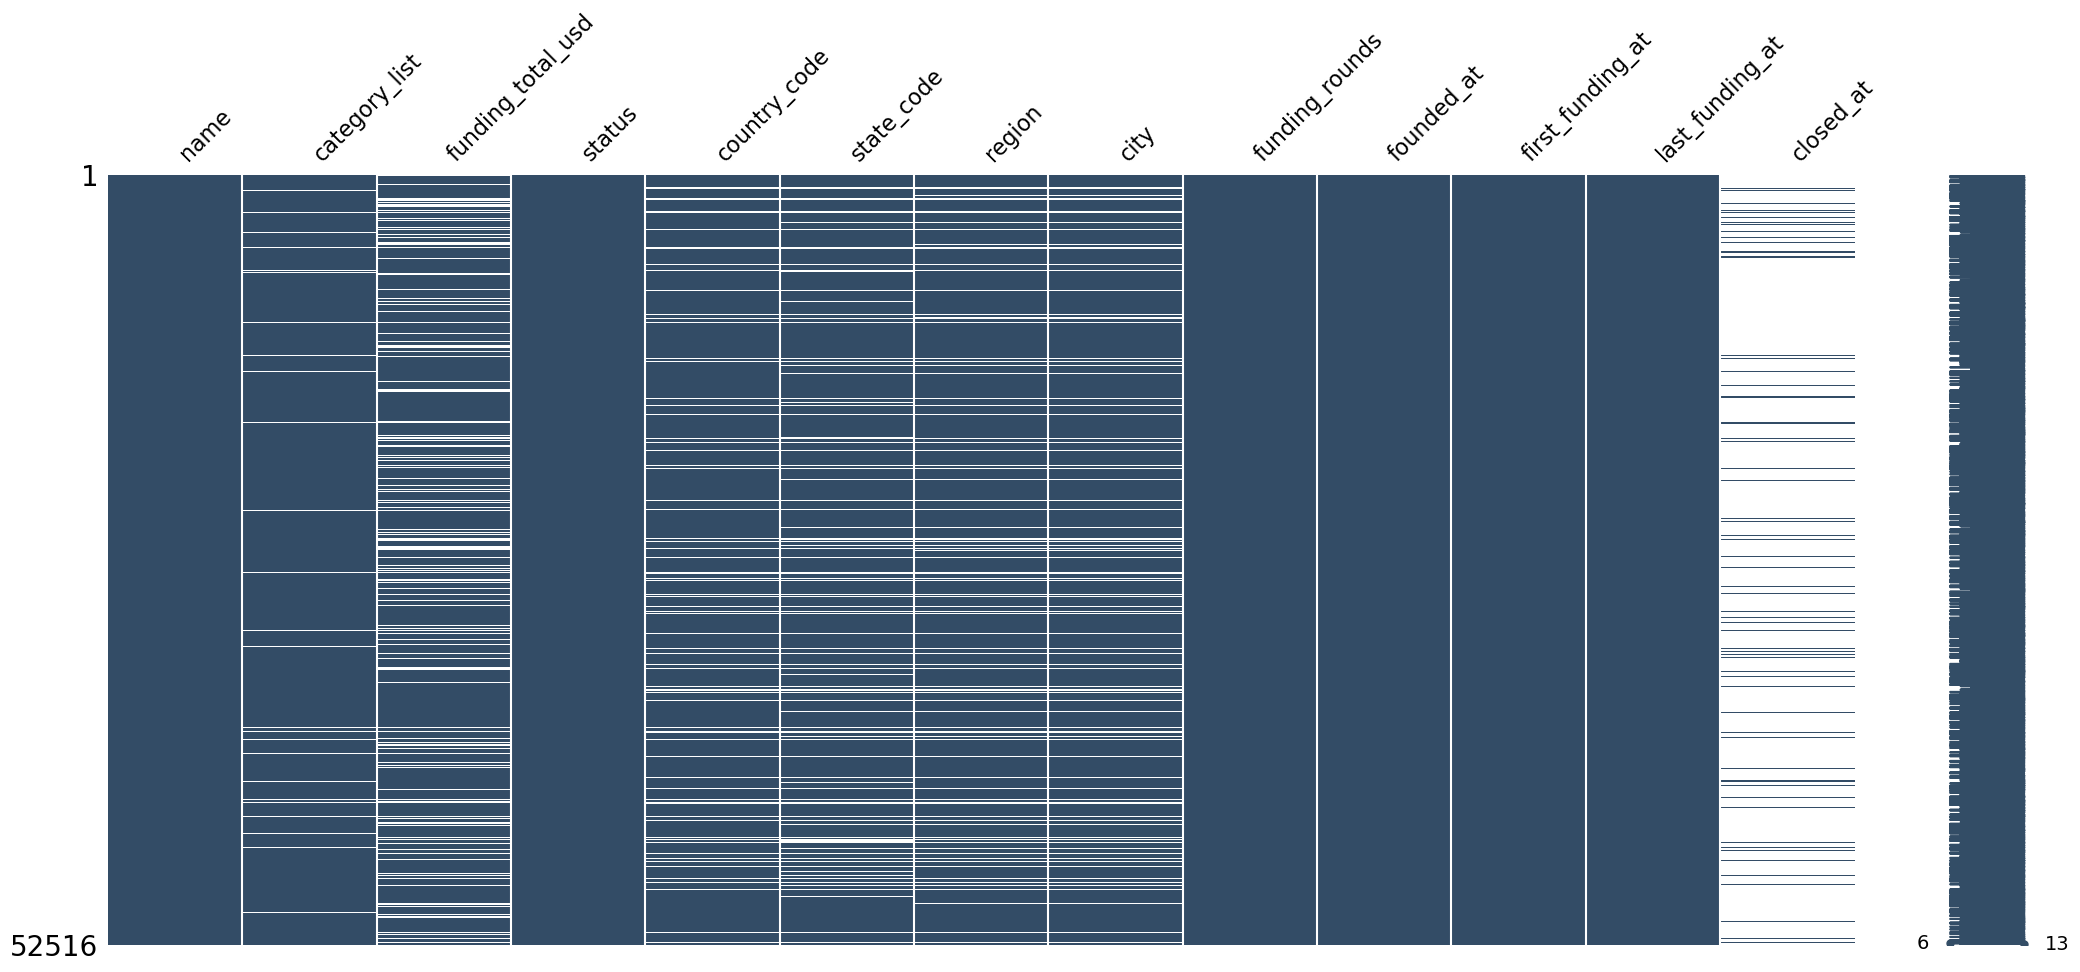

In [9]:
plt.figure(figsize=(8, 6))
msno.matrix(train, color=(0.2, 0.3, 0.4))
plt.show()

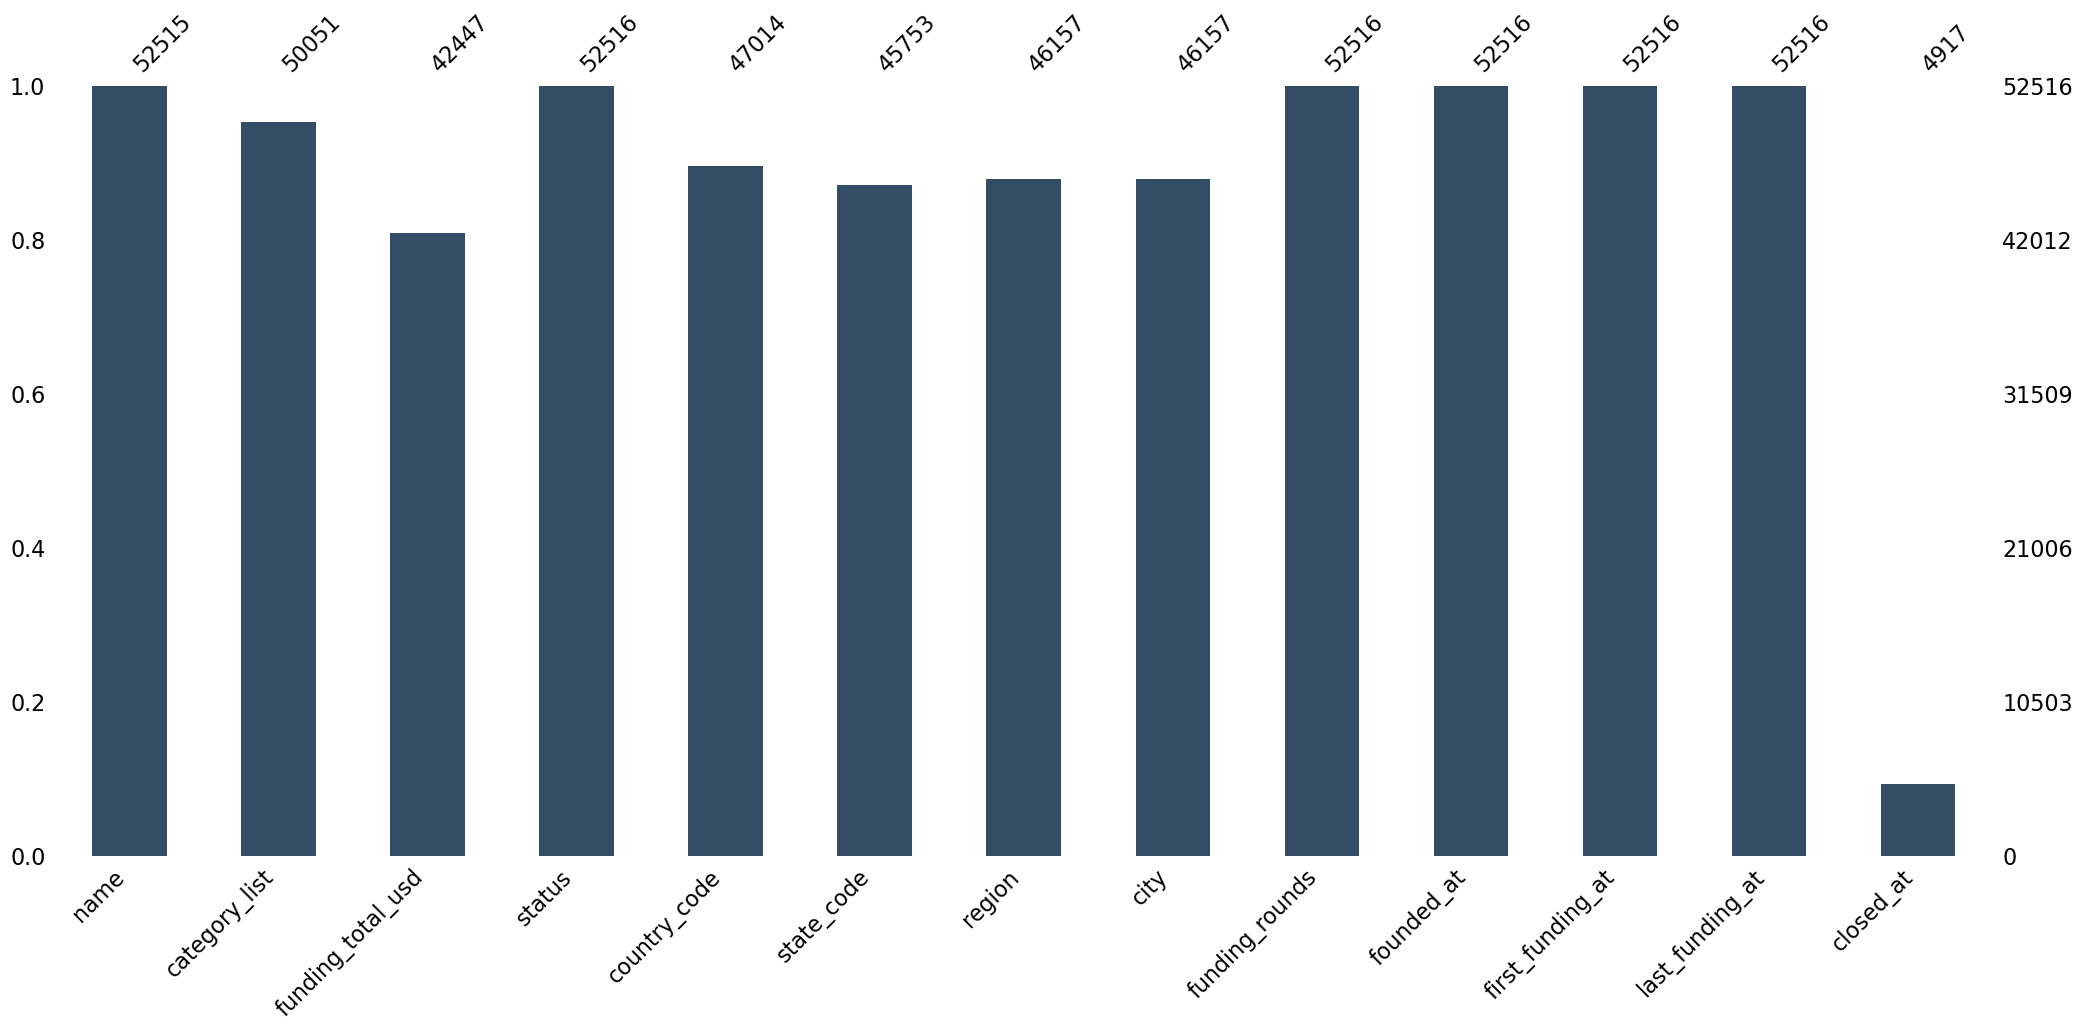

In [10]:
plt.figure(figsize=(8, 6))
msno.bar(train, color=(0.2, 0.3, 0.4))
plt.show()

В ходе анализа матрицы пропусков найдена следующая закономерность: у стартапов с неуказанным кодом штата также неуказаны код страны, регион и город. 
Барграф показал, что в у этих признаков количество пропусков примерно одинаковое. Также пропуски присутствуют в столбце с категориями. `funding_total_usd` также содержит пропуски. Посчитаем средний объем финансирования для стартапов в зависимости от числа раундов финансирования и вставим в пропущенные значения столбца эти средние, опираясь на число раундов. Столбец с информацие о дате закрытия почти пустой, т.к. очевидно, что в датасете есть компании, которые еще не приостановили свою деятельность. Также одно пропущенное значение присутствует в столбце с именами - заполним его на Unknown

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Последние 4 признака, согласно содержанию таблицы, имеют неверный тип данных. Испраим это 

In [12]:
train['founded_at'] = pd.to_datetime(train['founded_at'])
train['first_funding_at'] = pd.to_datetime(train['first_funding_at'])
train['last_funding_at'] = pd.to_datetime(train['last_funding_at'])
train['closed_at'] = pd.to_datetime(train['closed_at'])

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

Все верно! Теперь пойдем дальше

In [14]:
train['name'] = train['name'].fillna('unknown')

Посмотрим какое число раундов финансирования обычно встречается у компаний и какой медианный объем финансирования для каждого кол-ва раундов

In [15]:
mean_funding = train.groupby('funding_rounds')['funding_total_usd'].median()
mean_funding

funding_rounds
1        860000.0
2       2927171.0
3       7242588.0
4      15000000.0
5      25627280.0
6      36150000.0
7      46670000.0
8      67438045.5
9      61600000.0
10     59463635.0
11    129821462.5
12     74016526.5
13     42027500.0
14    132787385.0
15     79209599.0
16     63505195.0
17    103662749.0
18     63997160.0
19    242948825.0
Name: funding_total_usd, dtype: float64

А теперь заполним пропуски в столбце `funding_total_usd` медианным значением финансирования по раундам

In [16]:
train['funding_total_usd'] = train['funding_total_usd'].fillna(train['funding_rounds'].map(mean_funding)).astype('int64')

In [17]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,860000,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


Пропущенные значения корректно заполнились, идем дальше 

Столбец `category_list` содержит информацию о категории, к которой относится стартап. В толбце также присутствуют пропущенные значения, поэтому заполним их наиболее встречающейся категорией

In [18]:
print(train.category_list.value_counts().head(30))
print('Количество категорий', train.category_list.value_counts().shape[0])

category_list
Software                            3207
Biotechnology                       2905
E-Commerce                          1064
Mobile                               920
Clean Technology                     892
Curated Web                          853
Health Care                          744
Hardware + Software                  733
Games                                681
Enterprise Software                  671
Health and Wellness                  613
Manufacturing                        604
Advertising                          554
Education                            423
Semiconductors                       400
Real Estate                          338
Finance                              338
Consulting                           330
Social Media                         326
Security                             317
Hospitality                          278
Web Hosting                          277
Analytics                            261
Fashion                              254
Te

In [19]:
train.category_list.value_counts().tail(20)

category_list
Bicycles|E-Commerce|Retail|Transportation                                                 1
Consumer Electronics|Hardware|Interface Design|Internet|Television                        1
Beauty|Marketplaces                                                                       1
Android|Apps|Exercise|Fitness|Health and Wellness|Mobile|Software|Startups|Technology     1
Food Processing|Marketplaces|Services                                                     1
Enterprise Software|Gps|Location Based Services|Mobile                                    1
Product Design|Semiconductors|Technology                                                  1
Mobile|Networking|Photography|Web Hosting                                                 1
Accounting|Creative|Music|Video                                                           1
Content|Digital Media|Music|Software|Text Analytics                                       1
Augmented Reality|Mobile Games|Virtual Worlds                     

Для начала заполним пропущенные категории словом **Others**

In [20]:
train['category_list'] = train['category_list'].fillna('Others')

Мы имеем 22105 категорий стартапов. При этом есть категории, которые можно отнести к одной сфере (Например **Software** и **Graphics|Software|Startups**
Напишем функцию, которая будет искать в названиях категории ключевые слова и относить стартап к этой категории. )

In [21]:
def change_category(category):
    # для начала создадим списки с ключевыми словами
    it_keyword = ['Software', 'iOS', 'Android', 'Utilities', 'Apps', 'Web', 'Services', 'Hardware', 'Games', 'Internet', 'Search', 'Messaging', 'Game']
    medical_keyword = ['Biotechnology', 'Health', 'Medical', 'Medicine', 'Pharmaceuticals', 'Bio-Pharm', 'Hospitals']
    ecommerce_keyword = ['E-Commerce', 'Retail', 'Marketplaces', 'Online Shopping', 'Market Research']
    mobile_keyword = ['Mobile']
    technologies_keyword = ['Technology', 'Semiconductors', 'Nanotechnology', 'Consumer Electronics', 'Telecommunications', 'Electronics', 'Wireless']
    media_keyword = ['News', 'Media', 'Advertising', 'Social Media', 'Public Relations', 'Networking', 'Publishing', 'Communities', 'Marketing Automation']
    manufacturing_keyword = ['Manufacturing', 'Oil & Gas', 'Energy', 'Agriculture', 'Oil and Gas', 'Renewable Energies']
    education_keyword = ['Education']
    real_estate_keyword = ['Real Estate', 'Realty']
    finance_keyword = ['Finance', 'Banking', 'Insurance', 'Investment Management', 'FinTech', 'Bitcoin']
    consulting_keyword = ['Consulting', 'Legal']
    security_keyword = ['Security']
    travel_keyword = ['Hospitality', 'Travel', 'Entertainment', 'Food Processing', 'Restaurants', 'Specialty Foods']
    analytics_keyword = ['Analytics', 'Data']
    fashion_keyword = ['Fashion']
    sports_keyword = ['Sports', 'Fitness', 'Sporting Goods']
    creativity_keyword = ['Music', 'Photography', 'Design', 'Video']
    transport_keyword = ['Transportation', 'Public Transportation', 'Automotive',  'Logistics']
    

    if any(keyword in category for keyword in it_keyword):
        return 'Software'
    elif any(keyword in category for keyword in medical_keyword):
        return 'Medical'
    elif any(keyword in category for keyword in ecommerce_keyword):
        return 'E-commerce'
    elif any(keyword in category for keyword in mobile_keyword):
        return 'Mobile'
    elif any(keyword in category for keyword in technologies_keyword):
        return 'Technology'
    elif any(keyword in category for keyword in media_keyword):
        return 'Media'
    elif any(keyword in category for keyword in manufacturing_keyword):
        return 'Manufacturing'
    elif any(keyword in category for keyword in education_keyword):
        return 'Education'
    elif any(keyword in category for keyword in real_estate_keyword):
        return 'Realty'
    elif any(keyword in category for keyword in finance_keyword):
        return 'Finance'
    elif any(keyword in category for keyword in consulting_keyword):
        return 'Consulting'
    elif any(keyword in category for keyword in security_keyword):
        return 'Security'
    elif any(keyword in category for keyword in travel_keyword):
        return 'Travel'
    elif any(keyword in category for keyword in analytics_keyword):
        return 'Analytics'
    elif any(keyword in category for keyword in fashion_keyword):
        return 'Fashion'    
    elif any(keyword in category for keyword in sports_keyword):
        return 'Sports'
    elif any(keyword in category for keyword in creativity_keyword):
        return 'Creativity'
    elif any(keyword in category for keyword in transport_keyword):
        return 'Transport'    
    else:
        return 'Others'
    

In [22]:
train['categories'] = train['category_list'].apply(change_category)

In [23]:
train['categories'].value_counts()

categories
Software         21483
Medical           6880
Others            4449
E-commerce        3359
Technology        3106
Media             3101
Mobile            2272
Travel            1178
Manufacturing     1098
Finance            910
Education          865
Analytics          646
Security           579
Creativity         567
Consulting         508
Realty             484
Transport          462
Fashion            309
Sports             260
Name: count, dtype: int64

In [24]:
print('Количество категорий', train.categories.value_counts().shape[0])

Количество категорий 19


Теперь вместо 22105 категорий у нас всего 19. Посмотрим какие категории были отнесены в категорию `Others`

In [25]:
train[train['categories']== 'Others']['category_list'].value_counts().head(15)

category_list
Others                      2465
Nonprofits                    65
Consumer Goods                42
Local Businesses              35
Startups                      33
Consumers                     29
Pets                          29
Alumni                        27
Human Resources               21
Recruiting                    20
Environmental Innovation      19
SaaS                          19
Beauty                        16
Broadcasting                  16
3D Printing                   16
Name: count, dtype: int64

Т.к. перечисленные категории трудной отнести к одной из уже существующих, оставим их в категории **другие**

Пропущенные значения в столбцах с географической информацией заполним на **unknown**

In [26]:
train['country_code'] = train['country_code'].fillna('unknown')     
train['state_code'] = train['state_code'].fillna('unknown')           
train['region'] = train['region'].fillna('unknown')        
train['city'] = train['city'].fillna('unknown')  

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  int64         
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
 13  categories         52516 non-null  object        
dtypes: dat

Все пропуски заполнены! Столбец `closed_at` мы не трогаем, т.к. заполнять его по факту нечем

Теперь приступим к анализу дубликатов в наших данных

In [28]:
def duplicated_data(data):
    #Неявные дубликаты в строковых столбцах
    object_columns = data.select_dtypes(include='object').columns
    for column in object_columns:
        print(f'Cписок уникальных значений для столбца {column}')
        if column in data.columns:
            print(data[column].sort_values().unique())
            print()

In [29]:
duplicated_data(train.drop(['name'], axis=1))

Cписок уникальных значений для столбца category_list
['3D' '3D Printing' '3D Printing|3D Technology' ... 'mHealth|Mobile'
 'mHealth|Software' 'mHealth|Software|Therapeutics']

Cписок уникальных значений для столбца status
['closed' 'operating']

Cписок уникальных значений для столбца country_code
['ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BAH' 'BEL' 'BGD' 'BGR' 'BHR'
 'BLM' 'BLR' 'BLZ' 'BMU' 'BRA' 'BRN' 'BWA' 'CAN' 'CHE' 'CHL' 'CHN' 'CMR'
 'COL' 'CRI' 'CYM' 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP'
 'EST' 'FIN' 'FRA' 'GBR' 'GEO' 'GGY' 'GHA' 'GIB' 'GRC' 'GRD' 'GTM' 'HKG'
 'HND' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA' 'JAM' 'JEY'
 'JOR' 'JPN' 'KAZ' 'KEN' 'KHM' 'KNA' 'KOR' 'KWT' 'LAO' 'LBN' 'LIE' 'LKA'
 'LTU' 'LUX' 'LVA' 'MAF' 'MAR' 'MCO' 'MDA' 'MEX' 'MKD' 'MLT' 'MMR' 'MNE'
 'MOZ' 'MUS' 'MYS' 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN'
 'PER' 'PHL' 'POL' 'PRI' 'PRT' 'PRY' 'PSE' 'QAT' 'ROM' 'RUS' 'RWA' 'SAU'
 'SEN' 'SGP' 'SLV' 'SOM' 'SRB' 'SVK' 'SVN' 'S

Видимых дубликатов не обнаружено. 

В тестовом датафрейме у нас есть такой признак, как lifetime - это время существования стартапа в днях. Создадим такой признак в тренировочном датафрейме. Напомним, что дата формирования выгрузки **2018-01-01**, поэтому дни будут считаться именно до этой даты

In [30]:
train['lifetime'] = (train['closed_at'].fillna(pd.to_datetime('2018-01-01').normalize()) - train['founded_at']).dt.days

In [31]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Travel,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Medical,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Medical,4383
3,Sancilio and Company,Health Care,22250000,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,Medical,5114
4,WireTough Cylinders,Manufacturing,860000,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Manufacturing,2791


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  int64         
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
 13  categories         52516 non-null  object        
 14  lifeti

Теперь осмотрим датафрейм с тестовыми данными и приступим к исследовательскому анализу данных

In [33]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Те же самые проблемы:
 1. Пропущенные значения в стобце `category_list`
 2. Пропущенные значения в стобце `funding_total_usd`
 3. Пропущенные значения в столбцах `country_code`, `state_code`, `region`, `city`
 4. Неправильный тип данных в столбцах с датами

Заполнять их будем по той же стратегии, что и до этого

In [34]:
x_test['category_list'] =x_test['category_list'].fillna('Others')
x_test['categories'] = x_test['category_list'].apply(change_category)
x_test['categories'].value_counts()

categories
Software         5376
Medical          1703
Others           1104
E-commerce        840
Technology        791
Media             759
Mobile            576
Travel            301
Manufacturing     295
Finance           236
Education         225
Analytics         159
Security          133
Consulting        126
Creativity        123
Realty            118
Transport         115
Fashion            89
Sports             56
Name: count, dtype: int64

In [35]:
x_test['funding_total_usd'] = x_test['funding_total_usd'].fillna(x_test['funding_rounds'].map(mean_funding)).astype('int64')
x_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,categories
0,Crystalsol,Clean Technology,2819200,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Technology
1,JBI Fish & Wings,Hospitality,860000,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Travel
2,COINPLUS,Finance,428257,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance
3,Imagine Communications,Software|Video|Video Streaming,34700000,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software
4,DNA13,Software,4530000,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software


In [36]:
x_test['country_code'] = x_test['country_code'].fillna('unknown')     
x_test['state_code'] = x_test['state_code'].fillna('unknown')           
x_test['region'] = x_test['region'].fillna('unknown')        
x_test['city'] = x_test['city'].fillna('unknown')  

In [37]:
x_test['first_funding_at'] = pd.to_datetime(x_test['first_funding_at'])
x_test['last_funding_at'] = pd.to_datetime(x_test['last_funding_at'])

In [38]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  int64         
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  categories         13125 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(7)
memory usage: 1.2+ MB


Теперь отсортируем значения в тестовой выборке по столбцу с названием компаний, а заодно и проверим все ли наблюдения присутствуют в обеих выборках

In [39]:
set_x = set(x_test['name'].str.lower().sort_values().unique())
set_y = set(y_test['name'].str.lower().sort_values().unique())

# Находим разность множеств
result = list(set_x - set_y)

print('Количество значений, которые отсутствуют в одном из с столбцов', len(pd.Series(result)))

Количество значений, которые отсутствуют в одном из с столбцов 0


Все значения из x_test соответствуют значениям в y_test, отлично! Теперь отсортируем их 

In [40]:
x_test = x_test.sort_values('name')
x_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,categories
5157,#HASHOFF,Digital Media|Internet|Social Media,955000,USA,CO,Denver,Denver,2,2014-12-08,2015-08-11,1371,Software
7054,#waywire,Entertainment|News|Politics|Social Media,1750000,USA,NY,New York City,New York,1,2012-06-30,2012-06-30,2040,Media
6275,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,3406878,unknown,unknown,unknown,unknown,1,2014-01-30,2014-01-30,2142,Software
13036,01Games Technology,Games,41250,HKG,unknown,Hong Kong,Hong Kong,1,2014-07-01,2014-07-01,1746,Software
11018,1 Mainstream,Apps|Cable|Distribution|Software,5000000,USA,CA,SF Bay Area,Cupertino,1,2015-03-17,2015-03-17,2132,Software


In [41]:
y_test = y_test.sort_values('name')
y_test.head()

,name,status
5157,#HASHOFF,operating
7054,#waywire,operating
6275,"(THE) ONE of THEM,Inc.",closed
13036,01Games Technology,closed
11018,1 Mainstream,operating


Предобработку мы завершаем, переходим к исследовательскому анализу данных

### Вывод

В ходе предобработки данных мы провели следующие действия над данными:
1. Перевели тип данных из `object` в `datetime` в столбцах `first_funding_at`, `last_funding_at`, `closed_at`, `founded_at`
2. Заполнили пропуски в столбцах `name`, `region`, `city`, `country_code`, `state_code` на `unknown`
3. Заполнили пропуски в столбце `funding_rounds` медианными значениями по числу раундов финансирования
4. Написали функцию для объединения категорий стартапов `change_category` и сжали кол-во категорий с 22105 до 19. При этом пропущенные категории и категории, которые нельзя было отнести к одной из 18 были отнесены к категории `others`
5. Создали в тренировочном датасете признак `lifetime`, который содержит в себе кол-во дней существования стартапа (такой признак уже был в тестовом датасете)

## EDA

Начнем наше исследование с построения столбчатой диаграммы признака `categories`

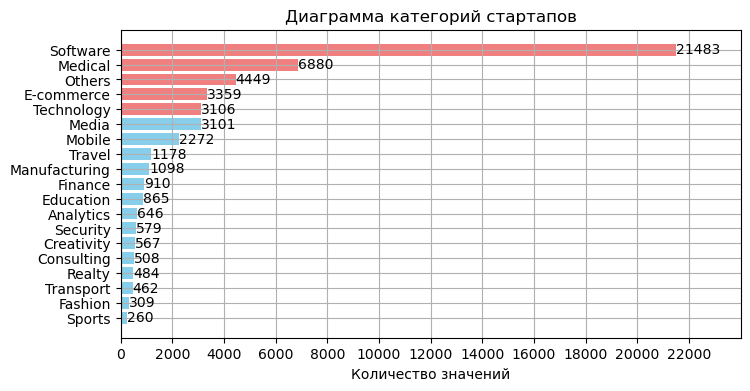

In [42]:
plt.figure(figsize=(8, 4)) 
bars = plt.barh(train['categories'].value_counts(ascending=True).index, 
                train['categories'].value_counts(ascending=True).values, 
                color=['skyblue' if i < (len(train['categories'].value_counts(ascending=True)) - 5) else 'lightcoral' for i in range(len(train['categories'].value_counts(ascending=True)))])

plt.xlabel('Количество значений')
plt.title('Диаграмма категорий стартапов')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.0f}', 
             va='center', ha='left', fontsize=10, color='black')
plt.xlim(0, 24000)
plt.xticks(range(0, 24000, 2000))
plt.grid(True)
plt.show()

По диаграмме можно заметить что в пятерке лидеров категорий стартапа находятся:
 1. Разработка программного обеспечения
 2. Медицина
 3. Другие
 4. Онлайн-продажи
 5. Технологии

Меньше всего стартапов, занимающихся модой и спортом. Теперь посмотрим какой успех у пятерки лидеров по продолжению деятельности

In [43]:
grouped = train.groupby(['categories', 'status']).size().unstack(fill_value=0)
grouped['total'] = grouped['closed'] + grouped['operating']
grouped = grouped.sort_values('total', ascending=True).tail()

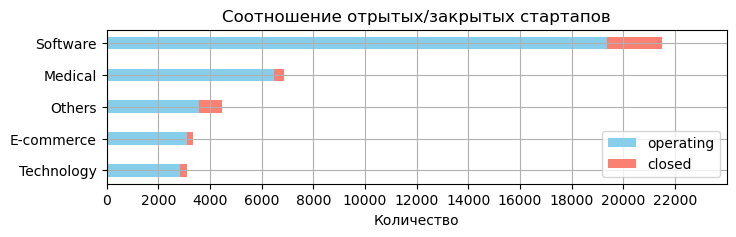

status,closed,operating,total,share
categories,,,,
Others,853,3596,4449,0.19
Software,2130,19353,21483,0.10
Technology,263,2843,3106,0.08
E-commerce,260,3099,3359,0.08
Medical,387,6493,6880,0.06


In [44]:
plt.figure(figsize=(8, 2))  # Размер графика (необязательно)

bar_height = 0.4

categories = grouped.index
num_categories = len(categories)
bar_positions = list(range(num_categories))

plt.barh(bar_positions, grouped['operating'], height=bar_height, label='operating', color='skyblue')

plt.barh(bar_positions, grouped['closed'], height=bar_height, label='closed', color='salmon', left=grouped['operating'])

plt.xlabel('Количество')
plt.title('Соотношение отрытых/закрытых стартапов')
plt.yticks(bar_positions, categories)
plt.legend()

plt.xlim(0, 24000)
plt.xticks(range(0, 24000, 2000))
plt.grid(True)
plt.show()

grouped['share'] = round((grouped['closed'] / grouped['total']), 2)
grouped.sort_values(['share'], ascending=False)

Наибольший процент (почти 20%) закрытых стартапов представлен в категории `Others`. Наверное это связано с тем, что стартапы выбирают непопулярные категории, которые имеют большой процент провальности по следующим причинам:

1. **Ограниченный спрос**. Непопулярные категории могут иметь ограниченный спрос на рынке, что затрудняет стартапам в этих областях достижение устойчивого роста и доходности.
2. **Высокие риски**. Инновации в непопулярных категориях часто связаны с высокими технологическими или рыночными рисками. Например, новаторские технологии могут быть сложными для внедрения или требовать значительных затрат на исследования и разработки.
3. **Недостаток поддержки**. Непопулярные категории могут сталкиваться с недостатком инфраструктуры, необходимой для успешного функционирования стартапа. Например, отсутствие развитой экосистемы, специализированных инвестиционных фондов или акселераторов.
4. **Сложности в привлечении инвестиций**. Инвесторы могут быть менее склонны рисковать в непопулярных категориях из-за неопределённости и потенциально долгого времени до возврата инвестиций.


Что касается категории `Software`, то тут процент провальности составил 10%. Вот некоторые причины по которым данная категория может оказаться неуспешной:

1. **Неудачная продуктовая стратегия**. Один из основных факторов неудачи стартапа в области программного обеспечения - это неправильная продуктовая стратегия. Это может включать в себя недостаточное понимание рыночных потребностей и ожиданий пользователей, недостаток уникального продукта или недостаток в решении этих потребностей.
2. **Технические трудности**. Разработка программного обеспечения может включать в себя много технических сложностей, таких как проблемы с масштабированием, совместимостью, безопасностью и производительностью. Недостаточное внимание к этим аспектам или неэффективное управление техническими ресурсами может привести к тому, что продукт не будет готов к использованию или не сможет соответствовать ожиданиям пользователей.
3. **Сильная конкуренция**. Рынок программного обеспечения обычно очень конкурентен, особенно в популярных сегментах. На стартап могут оказывать давление крупные игроки и другие стартапы, уже зарекомендовавшие себя на рынке. Неудачная стратегия маркетинга и продаж может привести к тому, что стартап будет уступать конкурентам и не сможет получить достаточное количество клиентов или пользователей.

Теперь мы изучим страны, в которых чаще всего организовывают стартапы

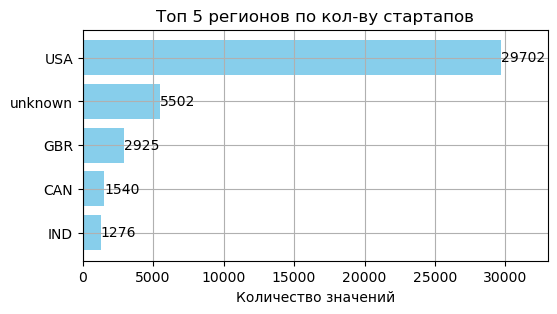

In [45]:
plt.figure(figsize=(6, 3))  

bars = plt.barh(train['country_code'].value_counts(ascending=True).tail().index, 
                train['country_code'].value_counts(ascending=True).tail().values, 
                color='skyblue' )
plt.xlabel('Количество значений')
plt.title('Топ 5 регионов по кол-ву стартапов')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.0f}', 
             va='center', ha='left', fontsize=10, color='black')
plt.xlim(0, 33000)
plt.xticks(range(0, 33000, 5000))
plt.grid(True)
plt.show()



Лидером по числу стартапов является США, там из почти 30000. На втором месте стартапы, названия регионов которых скрыты. Третье, четвертое и пятое места занимают Великобритания, Канада и Индия соответственно. При этом второе место занимают стартапы, регион которых нам неизвестен. Посмотрим соотношение открытых/закрытых стартапов.

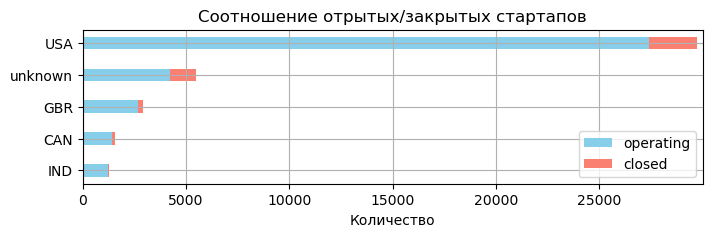

status,closed,operating,total,share
country_code,,,,
unknown,1286,4216,5502,0.23
CAN,128,1412,1540,0.08
GBR,234,2691,2925,0.08
USA,2284,27418,29702,0.08
IND,53,1223,1276,0.04


In [46]:
grouped = train.groupby(['country_code', 'status']).size().unstack(fill_value=0)
grouped['total'] = grouped['closed'] + grouped['operating']
grouped = grouped.sort_values('total', ascending=True).tail()

plt.figure(figsize=(8, 2))  # Размер графика (необязательно)

bar_height = 0.4

categories = grouped.index
num_categories = len(categories)
bar_positions = list(range(num_categories))

plt.barh(bar_positions, grouped['operating'], height=bar_height, label='operating', color='skyblue')

plt.barh(bar_positions, grouped['closed'], height=bar_height, label='closed', color='salmon', left=grouped['operating'])

plt.xlabel('Количество')
plt.title('Соотношение отрытых/закрытых стартапов')
plt.yticks(bar_positions, categories)
plt.legend()

plt.xlim(0, 30000)
plt.xticks(range(0, 30000, 5000))
plt.grid(True)
plt.show()

grouped['share'] = round((grouped['closed'] / grouped['total']), 2)
grouped.sort_values(['share'], ascending=False)

Доля закрытых стартапов в неизвестных регионах больше всего, она составила 23%. Второе место делят сразу 3 региона с относительно низким показателем безуспешности стартапов 8% - США, Великобритания и Канада

In [47]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Travel,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Medical,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Medical,4383
3,Sancilio and Company,Health Care,22250000,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,Medical,5114
4,WireTough Cylinders,Manufacturing,860000,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Manufacturing,2791


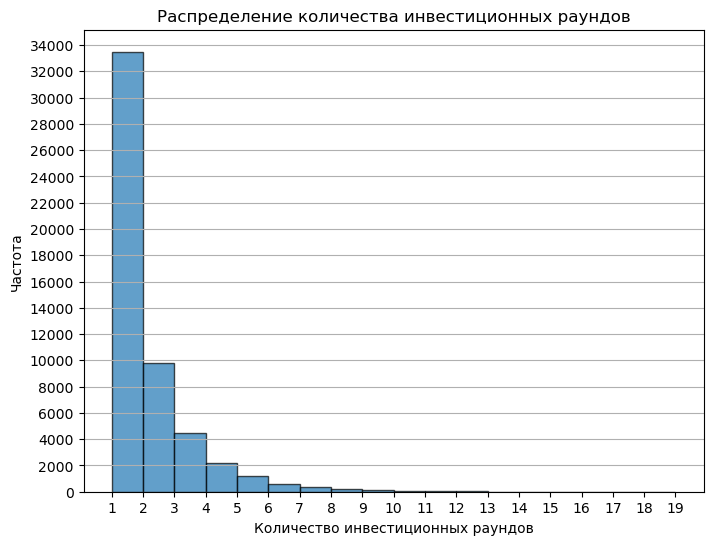

Доля наблюдений от общего числа


funding_rounds
1     63.769
2     18.691
3      8.474
4      4.168
5      2.224
6      1.173
7      0.649
8      0.333
9      0.208
10     0.120
11     0.088
12     0.042
13     0.017
16     0.011
15     0.010
14     0.010
17     0.006
18     0.006
19     0.002
Name: proportion, dtype: float64

In [48]:
plt.figure(figsize=(8, 6)) 

plt.hist(train['funding_rounds'], bins=range(1, 20), edgecolor='black', alpha=0.7) 

plt.xlabel('Количество инвестиционных раундов')
plt.ylabel('Частота')
plt.title('Распределение количества инвестиционных раундов')
plt.xticks(range(1, 20)) 
plt.yticks(range(0, 35000, 2000))
plt.grid(axis='y')  
plt.show()

print('Доля наблюдений от общего числа')
round(train['funding_rounds'].value_counts(normalize=True)*100, 3)

Почти 64% стартапов имеют всего лишь 1 инвестиционный раунд. 

18,7% - только два инвестиционных раунда

8,5% - три инвестиционных раунда

4% - четыре инвестиционных раунда

2% команий имеют 5 инвестиционных раундов

1% компаний имели 6 инвестиционных раундов

Чуть больше 1,5% компаний имели более 6 инвестиционных раундов

Такая вот статистика. Теперь посмотрим статистику по статусу компаний, у которых было более 6 инвестиционных раундов

In [49]:
train[train['funding_rounds'] > 6]['status'].value_counts(normalize=True)

status
operating    0.963198
closed       0.036802
Name: proportion, dtype: float64

Из компаний, количество инвестиционных раундов которых более шести закрылись всего лишь 4% с натяжкой. Очевидно такие компании имеют хорошую выживаемость за счет такого числа инвестиционных раундов. 

Изучим данные по объему финансирования

In [50]:
print('Мин объем финансирования', train.funding_total_usd.min())
print('Макс объем финансирования', train.funding_total_usd.max())
print('Средний объем финансирования', train.funding_total_usd.mean())
print('Медианный объем финансирования', train.funding_total_usd.median())

Мин объем финансирования 1
Макс объем финансирования 30079503000
Средний объем финансирования 14978122.105777286
Медианный объем финансирования 1021239.0


In [51]:
train[train['funding_total_usd']==1]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories,lifetime
11405,Sentic Technologies Inc,Information Technology|Internet|SaaS|Search Ma...,1,operating,USA,IL,Chicago,Chicago,1,2014-02-01,2015-11-12,2015-11-12,NaT,Software,1430


In [52]:
train[train['funding_total_usd']==30079503000]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories,lifetime
39186,Verizon Communications,Communications Infrastructure|Information Tech...,30079503000,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,NaT,Mobile,12505


В данных явно присутствуют значимые выбросы, которые будут мешать обучению нашей модели обучаться, а также усложнят процесс построения гистограммы. Для начала построим гистограмму с 90%-порогом

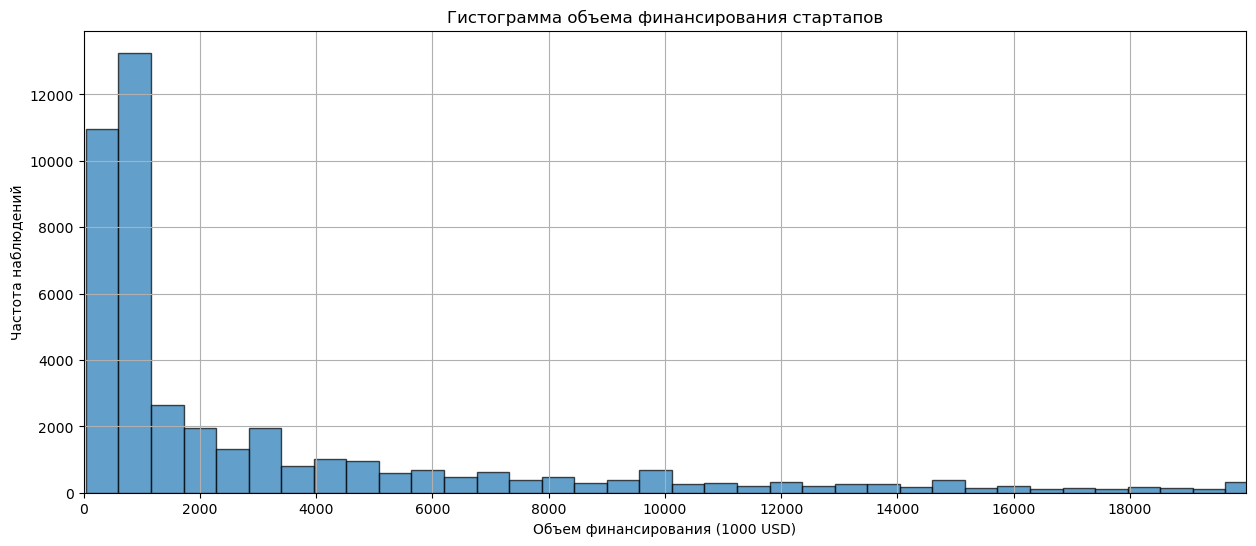

In [53]:
threshold_left = train['funding_total_usd'].quantile(.05)
threshold_right = train['funding_total_usd'].quantile(.95)

filtered_data = train[(train['funding_total_usd'] > threshold_left) & (train['funding_total_usd'] < threshold_right)]

plt.figure(figsize=(15,6))
(filtered_data['funding_total_usd']/1000).hist(bins=100, edgecolor='black', alpha=0.7)
plt.title('Гистограмма объема финансирования стартапов')
plt.xlabel('Объем финансирования (1000 USD)')
plt.ylabel('Частота наблюдений')
plt.xticks(range(0, 20000, 2000))
plt.xlim(0, 20000)
plt.show()

In [54]:
(filtered_data['funding_total_usd']/1_000).describe()

count    47264.000000
mean      5706.790374
std       9965.685352
min         37.639000
25%        700.000000
50%       1021.239000
75%       5639.895750
max      56049.556000
Name: funding_total_usd, dtype: float64

Какие выводы можно сделать:
1. Минимальный объем инвестиций, который был получен стартапом составил 37.6 тыс долларов
2. Максимальный объем инвестиций, полученный стартапом составил 56049 тыс. долларов
3. Среднее и медиана равны 5706.8 тыс. долларов и 1021.2 тыс. долларов соответственно. Заметно смещение из-за слишком больших значений в правом хвосте гистограммы.
4. Чаще всего в стартапы инвестируют суммы от 1.000 - 5.000.000 долларов. Значения больше встречаются крайне редко. 
До установки пороговых значений мы обнаружили несколько стартапов, инвестиционный объем которых составлял менее 100 долларов. При этом многие их этих стартапов продолжали существовать и не один год. Выведем их

In [55]:
train[train['funding_total_usd'] < 100]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories,lifetime
2316,Leinentausch / LeashSwap,Pets,68,operating,DEU,16,Berlin,Berlin,2,2013-03-31,2014-04-01,2015-01-15,NaT,Others,1737
8867,Snapstream,Software,50,operating,USA,GA,Atlanta,Marietta,1,2013-11-11,2013-11-09,2013-11-09,NaT,Software,1512
10220,Stirling Power,Design,29,operating,USA,ND,ND - Other,Michigan,1,2002-11-20,2004-04-28,2004-04-28,NaT,Creativity,5521
11023,Threatbutt,Animal Feed|Cyber Security|Data Security|Homel...,12,operating,USA,CA,SF Bay Area,Menlo Park,1,2015-04-20,2015-04-28,2015-04-28,NaT,Security,987
11405,Sentic Technologies Inc,Information Technology|Internet|SaaS|Search Ma...,1,operating,USA,IL,Chicago,Chicago,1,2014-02-01,2015-11-12,2015-11-12,NaT,Software,1430
15545,BLUErabbit,Education|Educational Games|Game Mechanics|Gam...,70,operating,MEX,9,Mexico City,Mexico City,1,2014-06-16,2015-10-30,2015-10-30,NaT,Software,1295
27332,Soundctl,Audio|Video Streaming,2,operating,USA,CA,SF Bay Area,Mountain View,1,2015-07-01,2015-09-23,2015-09-23,NaT,Creativity,915
27771,The Manly Man Can,Fashion,30,operating,USA,MI,Detroit,Pinckney,1,2014-10-26,2014-10-27,2014-10-27,NaT,Fashion,1163
29015,Romo Wind,Innovation Engineering|Optimization|Services,5,operating,DEU,8,DEU - Other,Straße,1,2011-08-18,2013-04-26,2013-04-26,NaT,Software,2328
32000,Solvo,Information Technology|Services|Software,20,operating,CRI,4,Costa Rica,Heredia,1,2014-01-31,2015-09-01,2015-09-01,NaT,Software,1431


Из 15 стартапов только один закрылся. Вероятно у этих компании имелись скрытые инвестиции или же они были на самофинансировании, раз прожили не один год.

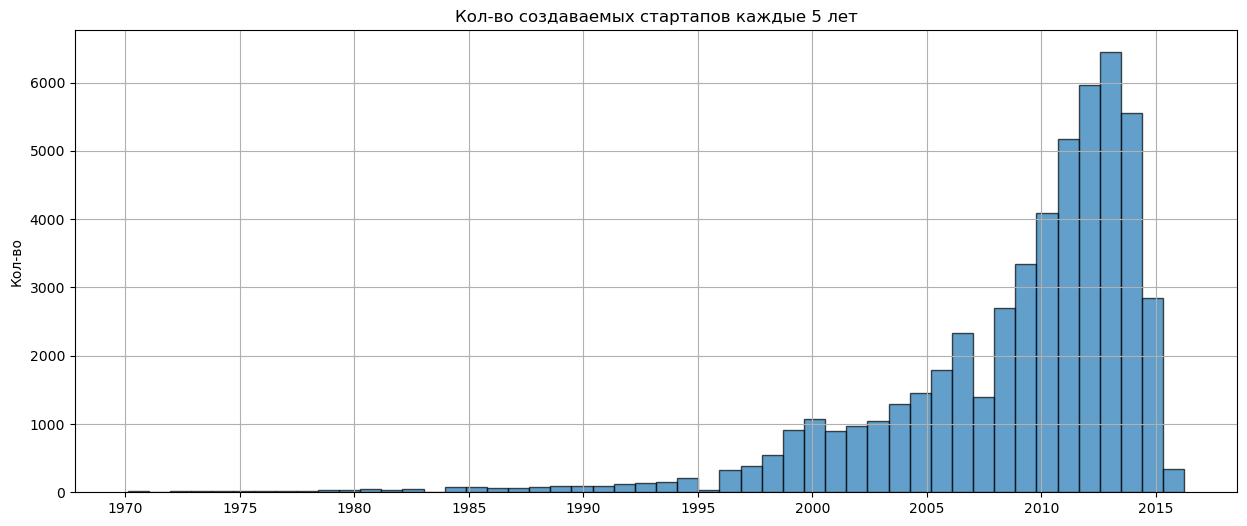

founded_at
2013    6954
2012    6704
2011    5688
2014    4900
2010    4455
Name: count, dtype: int64

In [56]:
plt.figure(figsize=(15,6))

plt.hist(train['founded_at'], edgecolor='black', alpha=0.7, bins=50)
plt.title('Кол-во создаваемых стартапов каждые 5 лет')
plt.ylabel('Кол-во')
plt.grid(True)
plt.show()
train['founded_at'].dt.year.value_counts().sort_values(ascending=False).head()

Глядя на гистограмму можно заметить, что в начале 21 века был всплеск числа создаваемых стартапов. И эта тенденция продолжалась вплоть до последнего наблюдения. Самое плодовитое пятилетие по числу созданных стартапов с 1970-2018 год является промежуток с 2010-2014 гг. 

Также в 2008 году наблюдается спад. Наверняка он связан с Экономическим кризисом 2008 г.

Исследуем число дней существования стартапов

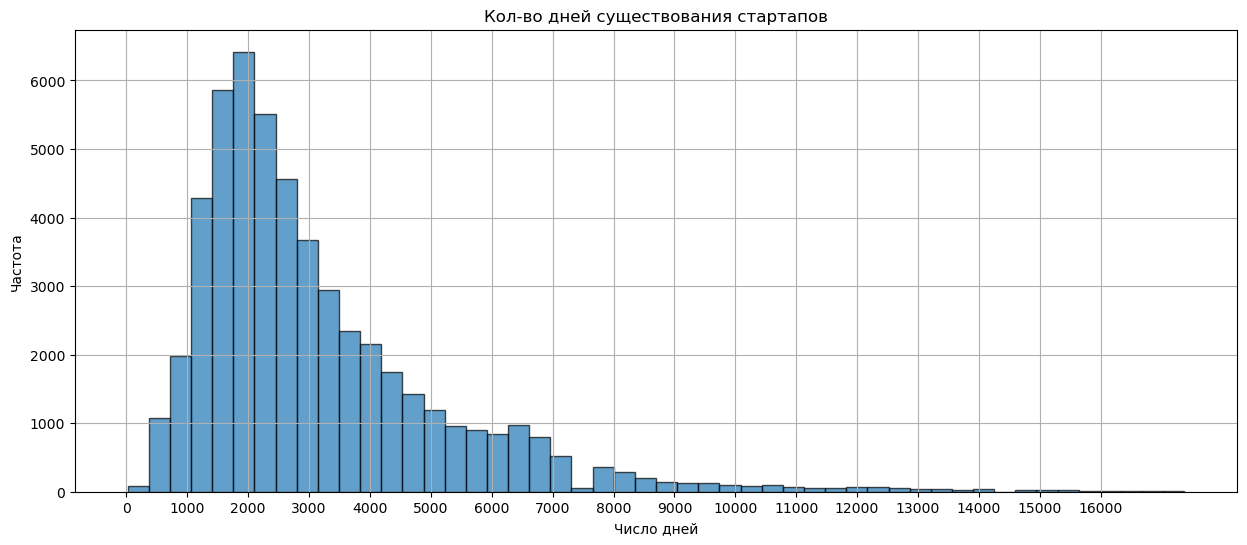

count    52516.000000
mean      3140.828129
std       2147.821070
min         19.000000
25%       1739.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64

In [57]:
plt.figure(figsize=(15,6))

plt.hist(train['lifetime'], edgecolor='black', alpha=0.7, bins=50)
plt.title('Кол-во дней существования стартапов')
plt.ylabel('Частота')
plt.xlabel('Число дней')
plt.xticks(range(0, 17000, 1000))
plt.grid(True)
plt.show()

train['lifetime'].describe()

Распределение кол-ва дней существования стартапов нормальное, скошенное влево из-за удлиненного правого хвоста. В выборке присутствует много значений, превышающих 7000 дней. Основной объем стартапов существовал от 3-19 лет. Малое число стартапов прожили более 20 лет 
Среднее количество дней, которое существует стартап составило 3141 (чуть больше 8,5 лет). Самое максимальное время, которое существовал стартап составило 17378 дней (почти 48 лет). Самый которкий стартап прожил всего 19 дней. 

Теперь посмотрим в какое время года чаще всего открываются стартапы

In [58]:
train['founded_at_month'] = train['founded_at'].dt.month.astype('int64')
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories,lifetime,founded_at_month
0,Lunchgate,Online Reservations|Restaurants,828626,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Travel,2998,10
1,EarLens,Manufacturing|Medical|Medical Devices,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Medical,4748,1
2,Reviva Pharmaceuticals,Biotechnology,35456381,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Medical,4383,1
3,Sancilio and Company,Health Care,22250000,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,Medical,5114,1
4,WireTough Cylinders,Manufacturing,860000,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Manufacturing,2791,5


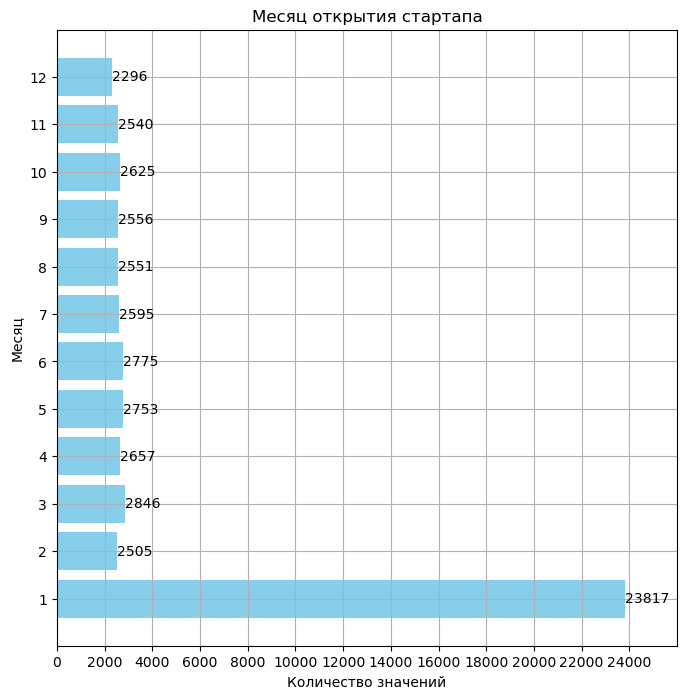

In [59]:
plt.figure(figsize=(8, 8)) 
bars = plt.barh(train['founded_at_month'].value_counts(ascending=True).index, 
                train['founded_at_month'].value_counts(ascending=True).values, 
                color=['skyblue' if i < (len(train['categories'].value_counts(ascending=True)) - 5) else 'lightcoral' for i in range(len(train['categories'].value_counts(ascending=True)))])

plt.xlabel('Количество значений')
plt.ylabel('Месяц')
plt.title('Месяц открытия стартапа')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.0f}', 
             va='center', ha='left', fontsize=10, color='black')
plt.xlim(0, 26000)
plt.xticks(range(0, 26000, 2000))
plt.yticks(range(1, 13, 1))
plt.grid(True)
plt.show()

Судя по диаграмме видно, что стартапы чаще всего регистрируют в январе. Таких стартапов подавляющее большинство. Распределение стартапов в остальные месяцы года примерно одинаковое. 

Рассмотрим региональное распреление стартапов

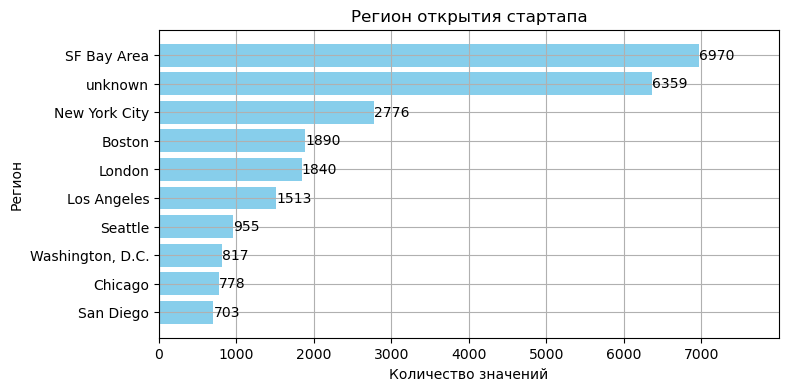

In [60]:
plt.figure(figsize=(8, 4)) 
bars = plt.barh(train['region'].value_counts(ascending=True).tail(10).index, 
                train['region'].value_counts(ascending=True).tail(10).values, 
                color=['skyblue' if i < (len(train['categories'].value_counts(ascending=True)) - 5) else 'lightcoral' for i in range(len(train['categories'].value_counts(ascending=True)))])

plt.xlabel('Количество значений')
plt.ylabel('Регион')
plt.title('Регион открытия стартапа')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.0f}', 
             va='center', ha='left', fontsize=10, color='black')
plt.xlim(0, 8000)
plt.xticks(range(0, 8000, 1000))
plt.grid(True)
plt.show()

На графике видно, что 8 регионов из 10 относятся к США, один регион представляет Великобританию и еще один представлен неизвестным регионом. Как мы выяснили, анализируя код страны ранее, США лидирует по кол-ву стартапов. 

Теперь оценим баланс классов в тренировочной и тестовой выборке, для того, чтобы лучше понять как нам работать с нашими моделями

In [61]:
train.status.value_counts(normalize=True)

status
operating    0.906371
closed       0.093629
Name: proportion, dtype: float64

In [62]:
y_test.status.value_counts(normalize=True)

status
operating    0.505524
closed       0.494476
Name: proportion, dtype: float64

Судя по результатам исследования в тренировочной выбоке наблюдается дисбаланс классов. Учтем это при моделировании

### Вывод

В ходе исследовательского анализа данных были найдены следующие закономерности в данных:

1. В пятерке лидеров направлений находятся следующие стартапы: **Разработка программного обеспечения, Медицина, Другие, Онлайн-продажи, Технологии.**
При этом меньше всего стартапов, занимающихся модой и спортом. Наверное, такие направления имеют меньший спрос, поэтому реже создаются подобные стартапы. При этом наибольший процент (почти 20%) закрытых стартапов представлен в категории Others. Наверное, это связано с тем, что стартапы выбирают непопулярные категории, которые имеют большой процент провальности по следующим причинам: ограниченный спрос, высокие риски, недостаток поддержки, сложности в привлечении инвестиций. Что касается самой популярной категории Software, то тут процент провальности составил 10%. Вот некоторые причины, по которым данная категория может оказаться неуспешной: неудачная продуктовая стратегия, технические трудности, сильная конкуренция.

2. **Лидером по числу стартапов является США**, там из почти 30000. На втором месте стартапы, названия регионов которых скрыты. Третье, четвертое и пятое места занимают Великобритания, Канада и Индия соответственно. При этом второе место занимают стартапы, регион которых нам неизвестен. Посмотрим соотношение открытых/закрытых стартапов. Доля закрытых стартапов в неизвестных регионах больше всего, она составила 23%. Второе место делят сразу 3 региона с относительно низким показателем безуспешности стартапов 8% - США, Великобритания и Канада.

3. **Почти 64% стартапов имеют всего лишь 1 инвестиционный раунд.** 18,7% - только два инвестиционных раунда. 8,5% - три инвестиционных раунда. 4% - четыре инвестиционных раунда. 2% компаний имеют 5 инвестиционных раундов. 1% компаний имели 6 инвестиционных раундов. Чуть больше 1,5% компаний имели более 6 инвестиционных раундов. Из компаний, количество инвестиционных раундов которых более шести, закрылись всего лишь 4% с натяжкой. Очевидно, такие компании имеют хорошую выживаемость за счет такого числа инвестиционных раундов.

4. **Минимальный объем инвестиций**, который был получен стартапом составил **37.6 тыс долларов.** 
Максимальный объем инвестиций, полученный стартапом составил** 56049 тыс. долларо**. **
Среднее и медиана равны 5706.8 тыс. долларов и 1021.2 тыс. долларов соответственн**о. Заметно смещение из-за слишком больших значений в правом хвосте гистограмм **.
Чаще всего в стартапы инвестируют суммы от 1.000 - 5.000.000 доллар**ов. Значения больше встречаются крайне ред В ходе исследования мы установили порог 10 %, дабы исключить выбросы. На этапе моделирования признаков мы скорее всего уберем экстремально высокие значения. До установки пороговых значений мы обнаружили несколько стартапов, инвестиционный объем которых составлял менее 100 долларов. При этом многие их этих стартапов продолжали существовать и не один год. Из 15 стартапов только один закрылся. Вероятно у этих компании имелись скрытые инвестиции или же они были на самофинансировании, раз прожили не один год.

5. В начале 21 века был всплеск числа создаваемых стартапов. И эта тенденция продолжалась вплоть до последнего наблюдения. **Самое плодовитое пятилетие по числу созданных стартапов с 1970-2018 год является промежуток с 2010-2014 гг.** 
Также в 2008 году наблюдается спад. Наверняка он связан с Экономическим кризисом 2008 

6. Распределение кол-ва дней существования стартапов нормальное, скошенное влево из-за удлиненного правого хвоста. В выборке присутствует много значений, превышающих 7000 дней. **Основной объем стартапов существовал от 3-19 лет.** Малое число стартапов прожили более 20 лет Среднее количество дней, которое существует стартап составило 3141 (чуть больше 8,5 лет). Самое максимальное время, которое существовал стартап составило 17378 дней (почти 48 лет). Самый которкий стартап прожил всего 19 дней.

7. Судя по помесячной диаграмме созданных стартапов видно, что **стартапы чаще всего регистрируют в январе.** Таких стартапов подавляющее большинство. Распределение стартапов в остальные месяцы года примерно одинаковое.

8. На графике регионального распределения стартапов видно, что 8 регионов из 10 относятся к США, один регион представляет Великобританию и еще один представлен неизвестным регионом. Как мы выяснили, анализируя код страны ранее, **США лидирует по кол-ву стартапов.**

9. По результатам исследования баланса классов **в тренировочной выбоке наблюдается дисбаланс классов.** Учтем это при моделированииг. ихнных раундовей.
иций.портом.

## Feature engineering и оценка корреляции

Перед тем как провести корреляционный анализ наших данных проведем небольшую чистку наших датасетов и при необходимости добавим интересующие нас признаки

In [63]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories,lifetime,founded_at_month
0,Lunchgate,Online Reservations|Restaurants,828626,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Travel,2998,10
1,EarLens,Manufacturing|Medical|Medical Devices,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Medical,4748,1
2,Reviva Pharmaceuticals,Biotechnology,35456381,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Medical,4383,1
3,Sancilio and Company,Health Care,22250000,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,Medical,5114,1
4,WireTough Cylinders,Manufacturing,860000,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Manufacturing,2791,5


1. Признак `name` - уникальный, он нам не нужен, т.к. скорее всего будет сильно коррелировать с другими переменными.
2. Признак `category_list` мы использовать не будем, вместо него оставим созданный `categories` - он будет удобнее для обучения.
3. Признак `funding_total_usd` лучше будет логарифмировать, чтобы сгладить распределение
4. Признак `country_code` - это единственный географический признак, который нам понадобится. В нем не так много категорий, как в остальных и по сути все остальные из него и вытекают.
5. Признак `funding_rounds` нам необходим для того, чтобы наша модель изучила закономерность числа раундов финансирования и успешности стартапа.
6. Признак `founded_at` мы удалим, т.к. у нас есть сильнокоррелирующий с ним признак `lifetime`. Признак `closed_at` нам тоже не пригодится.
7. Признаки `first_funding_at` и `last_funding_at` неинформативны. Вместо них прекрасно справятся число раундов и объем финансирования. Как вариант можно добавить разницу между первым и последним финансированием.
8. Также можно добавить средний объем финансирования за раунд.

На текущий момент это все признаки, которые нам понадобятся для моделирования. При необходимости набор признаков будет корректироваться. 
Для удобства напишем функцию

In [64]:
def feature_engineering(df):
    df['time_between_fundings'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

    # Дополнительные признаки
    df['average_funding_per_round'] = df['funding_total_usd'] / df['funding_rounds']
    df['log_funding_total_usd'] = np.log1p(df['funding_total_usd'])
    df['funding_per_year'] = df['log_funding_total_usd'] / (df['lifetime'] / 365)


    # Удаление ненужных признаков
    df.drop(columns=['name', 'first_funding_at', 'last_funding_at', 'category_list', 'region', 'state_code', 'city'], inplace=True)

    return df

In [65]:
train = feature_engineering(train)
train.head()

,funding_total_usd,status,country_code,funding_rounds,founded_at,closed_at,categories,lifetime,founded_at_month,time_between_fundings,average_funding_per_round,log_funding_total_usd,funding_per_year
0,828626,operating,CHE,2,2009-10-17,NaT,Travel,2998,10,1310,4.143130e+05,13.627525,1.659122
1,42935019,operating,USA,4,2005-01-01,NaT,Medical,4748,1,1393,1.073375e+07,17.575198,1.351084
2,35456381,operating,USA,3,2006-01-01,NaT,Medical,4383,1,681,1.181879e+07,17.383814,1.447660
3,22250000,operating,unknown,3,2004-01-01,NaT,Medical,5114,1,1051,7.416667e+06,16.917853,1.207473
4,860000,operating,USA,1,2010-05-12,NaT,Manufacturing,2791,5,0,8.600000e+05,13.664689,1.787034


In [66]:
train = train.drop(['founded_at', 'closed_at'], axis=1)
train.head()

,funding_total_usd,status,country_code,funding_rounds,categories,lifetime,founded_at_month,time_between_fundings,average_funding_per_round,log_funding_total_usd,funding_per_year
0,828626,operating,CHE,2,Travel,2998,10,1310,4.143130e+05,13.627525,1.659122
1,42935019,operating,USA,4,Medical,4748,1,1393,1.073375e+07,17.575198,1.351084
2,35456381,operating,USA,3,Medical,4383,1,681,1.181879e+07,17.383814,1.447660
3,22250000,operating,unknown,3,Medical,5114,1,1051,7.416667e+06,16.917853,1.207473
4,860000,operating,USA,1,Manufacturing,2791,5,0,8.600000e+05,13.664689,1.787034


Теперь то же самое проделаем с тестовым датасетом

In [67]:
x_test = feature_engineering(x_test)
x_test.head()

,funding_total_usd,country_code,funding_rounds,lifetime,categories,time_between_fundings,average_funding_per_round,log_funding_total_usd,funding_per_year
5157,955000,USA,2,1371,Software,246,477500.0,13.769468,3.665832
7054,1750000,USA,1,2040,Media,0,1750000.0,14.375127,2.572020
6275,3406878,unknown,1,2142,Software,0,3406878.0,15.041307,2.563061
13036,41250,HKG,1,1746,Software,0,41250.0,10.627431,2.221656
11018,5000000,USA,1,2132,Software,0,5000000.0,15.424949,2.640763


In [68]:
train = train.drop(['founded_at_month'], axis=1)

Мы имеем датасет с большим количество категориальных признаков, в которых перечисленно большое кол-во категорий. Также нам нужно проверить все эти признаки на мультиколлинеарность, лучший результат в такой ситуации покажет коэффициент корреляции phik

In [69]:
phik_matrix = train.phik_matrix(interval_cols=[
    'funding_total_usd', 
    'funding_rounds', 
    'lifetime', 
    'time_between_fundings', 
    'average_funding_per_round', 
    'log_funding_total_usd',
    'funding_per_year'
]
                                            )

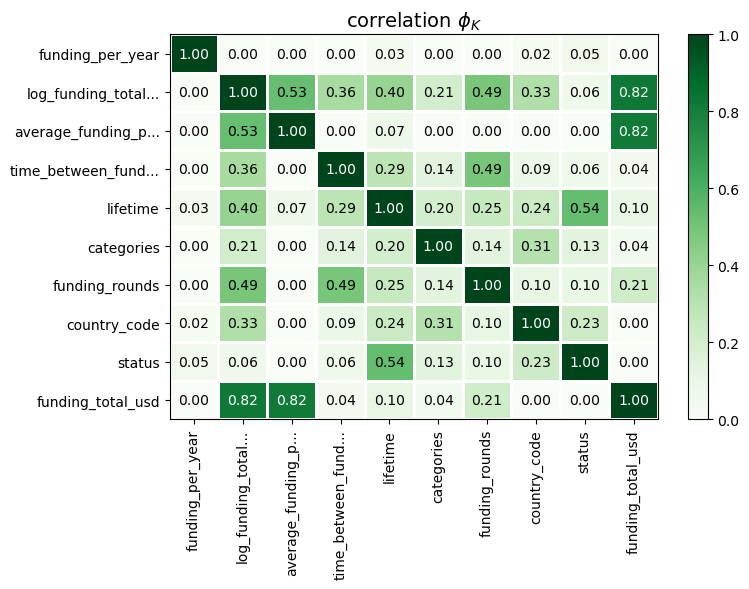

In [70]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(8,6))
plt.tight_layout()

Пойдем по порядку: 
1. `log_funding_total_usd`, `funding_total_usd` и `average_funding_per_round` имеют почти 100% корреляцию, оно и понятно, т.к. эти признаки вытекают из одного. Оставим логарифмированный признак, т.к. он имеет хоть и малую, но все же корреляцию с целевой переменной. Также логарифм финансирования имеет умеренную корреляцию с признаками `time_between_fundings` и `funding_rounds`, а также с `lifetime` и `соuntry_code`. Удалять мы ничего в этом случае не будем, т.к. сильной мультиколлинеарности не наблюдается. Понаблюдаем за нашей метрикой в ходе обучения.
2. `time_between_fundings` коррелирует с признаками `lifetime` и `funding_rounds`, корреляция умеренная, при этом с целевым признаком практически никакой корреляции не наблюдается.
3. `lifetime` имеет умеренную корреляцию с `time_between_fundings` и заметную с целевой переменной
4. `categories` имеет умеренную корреляцию с признаком `country_code`
5. `funding_rounds` имеет умеренную корреляцию с признаком `time_between_fundings`
6. С нашей целевой переменной полность отсутствует корреляция у признаков, относящихся с к объему финансирования, помимо логарифма и очень слабая корреляция наблюдается с признаком `funding_rounds`. По результатам моделирования будем решать оставлять этот признак или нет.

Теперь исключим из нашей обучающей выборки ненужные признаки и приступим к моделированию

In [71]:
train = train.drop(['average_funding_per_round', 'funding_total_usd'], axis=1)

In [72]:
train.sample()

,status,country_code,funding_rounds,categories,lifetime,time_between_fundings,log_funding_total_usd,funding_per_year
28834,operating,USA,1,Software,6295,0,13.664689,0.792313


Готово! Осталось только подогнать данные в тестовой выборке и можно начинать моделирование

In [73]:
x_test.sample()

,funding_total_usd,country_code,funding_rounds,lifetime,categories,time_between_fundings,average_funding_per_round,log_funding_total_usd,funding_per_year
4391,860000,POL,1,2397,Medical,0,860000.0,13.664689,2.080772


In [74]:
x_test = x_test.drop(['funding_total_usd', 'average_funding_per_round'], axis=1)

In [75]:
x_test.head(1)

,country_code,funding_rounds,lifetime,categories,time_between_fundings,log_funding_total_usd,funding_per_year
5157,USA,2,1371,Software,246,13.769468,3.665832


Теперь установим порядок признаков в тестовой выборке таким же, как и в тренировочной

In [76]:
x_test = x_test[train.drop(['status'], axis=1).columns]

In [77]:
x_test.head(1)

,country_code,funding_rounds,categories,lifetime,time_between_fundings,log_funding_total_usd,funding_per_year
5157,USA,2,Software,1371,246,13.769468,3.665832


Все сделано правильно! Приступаем к моделированию

## Пайплайн

Для пайплайна будем использовать 3 модели:
1. LogisticRegression(solver, class_weight, max_iter, random_state)
2. DecisionTreeClassifier(min_samples_split, class_weight, max_depth, min_samples_leaf, random_state)
3. KNeighborsClassifier

Указываем параметр class_weight='balanced', т.к. наш таргет несбалансирован

Для оценки качества модели используем f1_score

Пайплайн будем прогонять через RandoomizedSearchCV, т.к. у нас слишком много наблюдений и это ускорит обучение нашей модели

Столбцы для предобработки:
1. Категориальные (country_code, categories)
2. Количественные (funding_rounds, lifetime, time_between_fundings, log_funding_total_usd)

In [78]:
RANDOM_STATE=12345

x_train = train.drop(['status'], axis=1)
y_train = train['status']
y_test = y_test['status']

num_columns = ['lifetime', 'time_between_fundings', 'log_funding_total_usd', 'funding_per_year']
ohe_columns = ['country_code', 'categories', 'funding_rounds']

In [79]:
lencoder = LabelEncoder()
y_train_encoded = lencoder.fit_transform(y_train)
y_test_encoded = lencoder.transform(y_test)
lencoder.classes_

array(['closed', 'operating'], dtype=object)

In [80]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
]) 

In [85]:
%%time

param_distributions = [
    {
        'models': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 19),
    },
    {
        'models': [LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_iter': range(100, 500),
#        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__n_estimators': range(10, 100),
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 19),
    }
]


randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5,
    n_iter=100
)

randomized_search.fit(x_train, y_train_encoded) 

CPU times: total: 16.3 s
Wall time: 9min 53s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['country_code',
                                                                                'categories',
                                                                                'funding_rounds']),
                                                                              ('num',
                                                                               StandardScale...
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestClassifier(class_weight='balanced',
                                                                           max_depth=19,
                                                                           min_samples_leaf=2,
                                                                           min_samples_split=11,
                                                                           n_estimators=79,
                                                                           random_state=12345)],
                                         'models__max_depth': range(2, 20),
                                         'models__min_samples_leaf': range(1, 19),
                                         'models__min_samples_split': range(2, 20),
                                         'models__n_estimators': range(10, 100)}],
                   random_state=12345, scoring='f1')

In [86]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['country_code', 'categories',
                                                   'funding_rounds']),
                                                 ('num', StandardScaler(),
                    

In [87]:
print('Метрика f1 для лучшей модели:', randomized_search.best_score_)

Метрика f1 для лучшей модели: 0.9568601051506995


In [88]:
print('Метрика f1 на тестовой выборке:\n', f1_score(y_test_encoded, randomized_search.predict(x_test)))

C:\conda\Lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика f1 на тестовой выборке:
 0.6389073213890732
